In [ ]:
import pandas as pd
from typing import Optional
import shap
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error
from pycaret.regression import *
from sklearn.neighbors import KNeighborsRegressor

from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from sklearn.model_selection import TimeSeriesSplit
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
# import time_series_module_2 as ts

from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder

# 1. Pizza 
with the highest ration in sales \
Training the model to have an extra inventory

In [ ]:
# prepare data to train 
X_trainval = pd.read_csv(r'/Users/hwangjong-won/Desktop/sk/dataset/order_set/last_pizza_X_train.csv', index_col=0, decimal=',')
y_trainval = pd.read_csv(r'/Users/hwangjong-won/Desktop/sk/dataset/order_set/last_pizza_y_train.csv', index_col=0, decimal=',')

X_test = pd.read_csv(r'/Users/hwangjong-won/Desktop/sk/dataset/order_set/pizza_X_test.csv', index_col=0, decimal=',')
y_test = pd.read_csv(r'/Users/hwangjong-won/Desktop/sk/dataset/order_set/pizza_y_test.csv', index_col=0, decimal=',')

pd.set_option('display.float_format', '{:.20f}'.format)
# define function to convert 
def convert_to_float(column):
    return column.astype(float)  

# apply converting function to multiple columns 
X_columns_to_convert = X_trainval.columns
X_trainval[X_columns_to_convert] = X_trainval[X_columns_to_convert].apply(convert_to_float)
X_test[X_columns_to_convert] = X_test[X_columns_to_convert].apply(convert_to_float)

y_columns_to_convert = y_trainval.columns
y_trainval[y_columns_to_convert] = y_trainval[y_columns_to_convert].apply(convert_to_float)
y_test[y_columns_to_convert] = y_test[y_columns_to_convert].apply(convert_to_float)

col=X_trainval.columns

# split train and validation data 
X_train = X_trainval[:int(len(X_trainval)*0.8)] 
X_val = X_trainval[int(len(X_trainval)*0.8):] 

y_train = y_trainval[:int(len(y_trainval)*0.8)] 
y_val = y_trainval[int(len(y_trainval)*0.8):] 

med = np.exp(X_train['Order']).median()
bz_high = med*0.1
bz_low = med*0.1/2

def preprocess(x_train, x_valid, x_test): 
    tmp_x_train = x_train.copy()
    tmp_x_valid = x_valid.copy()
    tmp_x_test  = x_test.copy()

    tmp_x_train.reset_index(drop=True, inplace=True)
    tmp_x_valid.reset_index(drop=True, inplace=True)
    tmp_x_test.reset_index(drop=True, inplace=True)

    
    cat_columns = tmp_x_train.select_dtypes(include='object').columns # Store the column names before transformation
    num_columns = tmp_x_train.select_dtypes(include=['int', 'float']).columns

    # Apply transformations separately for numerical and categorical columns
    transformer = PowerTransformer(method='yeo-johnson')
    tmp_x_train[num_columns] = transformer.fit_transform(tmp_x_train[num_columns])
    tmp_x_valid[num_columns] = transformer.transform(tmp_x_valid[num_columns])
    tmp_x_test[num_columns]  = transformer.transform(tmp_x_test[num_columns])

    # scaler = StandardScaler(), does not change the shape of scale
    # tmp_x_train[num_columns] = scaler.fit_transform(tmp_x_train[num_columns])
    # tmp_x_valid[num_columns] = scaler.transform(tmp_x_valid[num_columns])
    # tmp_x_test[num_columns]  = scaler.transform(tmp_x_test[num_columns])

    return tmp_x_train, tmp_x_valid, tmp_x_test 

# Assuming you have X_train, X_val, and X_test defined elsewhere
X_train, X_val, X_test = preprocess(X_train, X_val, X_test)

In [ ]:
data = X_train['Order'].to_numpy() # convert X_train['Order'] data to NumPy array
sorted_data = np.sort(data) # sort data
a50 = abs(np.percentile(sorted_data, 50))
X_trainval = pd.concat([X_train, X_val], axis=0)

X = pd.concat([X_trainval, X_test], axis=0)
X = X.reset_index()
X = X.drop(['index'],axis=1)
# print('X len:', len(X))
X = np.array(X)
sequence_length = 4

# Reshape the training data
X = np.array([X[i:i+sequence_length, :] for i in range(len(X) - sequence_length + 1)]) # split into train, val, test

X_train_tensor = X[:-(len(X_test)+len(X_val))]
X_val_tensor = X[-(len(X_test)+len(X_val)): -len(X_test)]
X_test_tensor = X[ -len(X_test):]
print('X_train_tensor:', len(X_train_tensor))
print('X_val_tensor:', len(X_val_tensor))
print('X_test_tensor:', len(X_test_tensor))
print(len(X_train_tensor)+len(X_val_tensor)+len(X_test_tensor))

X len: 157
X_train_tensor: 113
X_val_tensor: 29
X_test_tensor: 12
154


In [ ]:
y = pd.concat([y_trainval, y_test], axis=0)
y = y.reset_index()
y = y.drop(['index'],axis=1)
print('y len:', len(y))

y = np.array(y)
sequence_length = 4

# Reshape the training data
y = np.array([y[i:i+sequence_length, :] for i in range(len(y) - sequence_length + 1)]) # split into train, val, test 
# y_train_reshaped = y_train_arr[sequence_length - 1:]

y_train_tensor = y[:-(len(y_test)+len(y_val))]
y_val_tensor = y[-(len(y_test)+len(y_val)): -len(y_test)]
y_test_tensor = y[ -len(y_test):]

print('y_train_tensor:', len(y_train_tensor))
print('y_val_tensor:', len(y_val_tensor))
print('y_test_tensor:', len(y_test_tensor))

print(len(y_train_tensor)+len(y_val_tensor)+len(y_test_tensor))

y len: 157
y_train_tensor: 113
y_val_tensor: 29
y_test_tensor: 12
154


In [ ]:
# function to reverse log transformed data to original - used for checking the output value
def reverse_ln_transformation(log_transformed_data):
    return np.exp(log_transformed_data)

In [ ]:
class business_Metrics:
    def __init__(self, high_order, low_order):
        self.high_order = high_order
        self.low_order = low_order

    # defining customed loss function using Numpy 
    def custom_loss(self, y_true, y_pred):
        tensor_data = y_pred- y_true

        condition_negative = tensor_data < self.low_order
        condition_positive = (self.low_order >= tensor_data) & (tensor_data <= self.high_order)
        condition_temp = tensor_data >= self.high_order

        modified_values = tf.where(condition_negative, tf.abs(tensor_data), tensor_data-self.low_order)
        modified_values = tf.where(condition_positive, tf.constant(0, dtype=tf.float32), modified_values)
        modified_values = tf.where(condition_temp, tf.abs(tensor_data), tensor_data - self.high_order)
        mse = tf.reduce_mean(tf.square(modified_values)) # calculate modified value's MSE 
        return mse

    def ml_loss(self, y_true, y_pred):
        ml_data = np.array(list(pd.DataFrame(y_pred, columns=['y'])['y'])) - np.array(list(pd.DataFrame(y_true, columns=['y'])['y']))
        for idx, i in enumerate(ml_data):
            if i < self.low_order:
                ml_data[idx] = abs(i)
            elif i > self.high_order:
                ml_data[idx] = i - self.high_order
            else:
                ml_data[idx] = 0
        mse = np.mean((ml_data) ** 2)
        return np.sqrt(mse)

    def ml_loss_mape(self, y_true, y_pred):
        ml_data = np.array(list(pd.DataFrame(y_pred, columns=['y'])['y'])) - np.array(list(pd.DataFrame(y_true, columns=['y'])['y']))
        for idx, i in enumerate(ml_data):
            if i < self.low_order: # 
                ml_data[idx] = i-self.low_order
            elif i > self.high_order:
                ml_data[idx] = i - self.high_order
            else:
                ml_data[idx] = 0
        return np.mean(np.abs((ml_data) / np.array(y_true)))
        
    def ml_loss_mape_point(self, y_true, y_pred):
        ml_data = np.array(list(pd.DataFrame(y_pred, columns=['y'])['y'])) - np.array(list(pd.DataFrame(y_true, columns=['y'])['y']))
        for idx, i in enumerate(ml_data):
            if i < self.low_order: # 
                ml_data[idx] = i-self.low_order
            elif i > self.high_order:
                ml_data[idx] = i - self.high_order
            else:
                ml_data[idx] = 0
        return np.mean(np.abs((ml_data) / np.array(y_true)))

    # defining MSE caculation function 
    def mse(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))
    
    
    def ml_loss_mape1(self, y_true, y_pred):
        ml_data =  np.array(list(pd.DataFrame(y_pred, columns=['y'])['y'])) - np.array(list(pd.DataFrame(y_true, columns=['y'])['y']))
        for idx, i in enumerate(ml_data):
            if self.high_order >= i >= self.low_order:
                y_pred[idx] = y_true[idx]
            elif self.high_order < i:
                y_pred[idx] = y_pred[idx] - self.high_order               
            else:
                y_pred[idx] = y_pred[idx] - self.low_order
        return mean_absolute_percentage_error(y_true, y_pred)

In [ ]:
# functions of spliting time seiries data 
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]
            

class RandomBlockingTimeSeriesSplit():
    def __init__(self, n_splits, random_state=None):
        self.n_splits = n_splits
        self.random_state = random_state
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        
        rng = np.random.RandomState(self.random_state)
    
        margin = 0
        for i in range(self.n_splits):
            start = rng.randint(0, n_samples - k_fold_size + 1)  # Choose a random starting point
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]
            
class Random_Blocking_TimeSeries_Split():
    def __init__(self, n_splits, train_length, test_length, random_state=None):
        self.n_splits = n_splits
        self.train_length = train_length
        self.test_length = test_length
        self.random_state = random_state
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        indices = np.arange(n_samples)
        
        rng = np.random.RandomState(self.random_state)
    
        for i in range(self.n_splits):
            train_start = rng.randint(0, n_samples - self.train_length - self.test_length + 1)
            train_stop = train_start + self.train_length
            test_start = train_stop
            test_stop = test_start + self.test_length
            
            yield indices[train_start: train_stop], indices[test_start: test_stop]

In [ ]:
# set parameters and directory 
high = a50*0.1 # positive value 
low = -(a50*0.1*0.5) # negative value
batch_size = 2
epochs = 5000
n_splits = 5  # Number of splits/folds
learning_rate = 0.01

folder = 'last_model/'
full = f'pizza_temp/32_16_1_batch{batch_size}_epochs{epochs}_learningrate{learning_rate}_n_splits{n_splits}check'
best_filename = folder+f'{full}.h5'

data = np.concatenate((X_train_tensor, y_train_tensor), axis=2) # concatenate training and target data to one 
tscv = TimeSeriesSplit(n_splits=n_splits) # data split using TimeSeriesSplit

# create model and compile 
sequence_length = X_train_tensor.shape[1]
features = X_train_tensor.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(sequence_length, features)))  # first LSTM layer
model.add(LSTM(16, activation='relu'))  # second LSTM layer
model.add(Dense(1, activation='linear'))  # output layer 

loss_metric = business_Metrics(high, low)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss_metric.custom_loss)

# Perform training and validation for each fold.
for train_idx, val_idx in tscv.split(data):
    X_train_fold = data[train_idx, :, :-1]
    y_train_fold = data[train_idx, :, -1]
    X_val_fold = data[val_idx, :, :-1]
    y_val_fold = data[val_idx, :, -1]

    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=50)
    
    modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=best_filename,
        verbose=1,
        save_best_only=True,
    )

    history = model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[es_callback, modelckpt_callback],
                        shuffle=False)


Epoch 1/5000


 1/12 [=>............................] - ETA: 7s - loss: 53.8425
Epoch 1: val_loss improved from inf to 22.77008, saving model to last_model/pizza_temp/32_16_1_batch2_epochs5000_learningrate0.01_n_splits5check.h5
12/12 [==============================] - 1s 16ms/step - loss: 15.2097 - val_loss: 22.7701
Epoch 2/5000
 1/12 [=>............................] - ETA: 0s - loss: 53.6151
Epoch 2: val_loss did not improve from 22.77008
12/12 [==============================] - 0s 4ms/step - loss: 19.5715 - val_loss: 28.7095
Epoch 3/5000
 1/12 [=>............................] - ETA: 0s - loss: 0.5393
Epoch 3: val_loss did not improve from 22.77008
12/12 [==============================] - 0s 3ms/step - loss: 1.6607 - val_loss: 29.7102
Epoch 4/5000
 1/12 [=>............................] - ETA: 0s - loss: 0.5641
Epoch 4: val_loss did not improve from 22.77008
12/12 [==============================] - 0s 3ms/step - loss: 0.5098 - val_loss: 32.0134
Epoch 5/5000
 1/12 [=>............................] - ET

In [ ]:
X_train_val_tensor = np.concatenate((X_train_tensor, X_val_tensor), axis=0)
y_train_val_tensor = np.concatenate((y_train_tensor, y_val_tensor), axis=0)
previous_model = tf.keras.models.load_model(best_filename, 
                 custom_objects={'custom_loss': business_Metrics(high,low).custom_loss}) # Load the previous model's parameter and compile information 
learning_rate = previous_model.optimizer.lr.numpy()  # the learning rate of previous model 
sequence_length = X_train_val_tensor.shape[1] # Create and compile a model for the combined data.
features = X_train_val_tensor.shape[2]

model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(sequence_length, features)))  
model.add(LSTM(16, activation='relu'))  
model.add(Dense(1, activation='linear'))  
model.set_weights(previous_model.get_weights()) # copy weights of previous model to new model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # compile model
model.compile(optimizer=optimizer, loss=loss_metric.custom_loss)
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=50) # set previously set callback 
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=best_filename,
    verbose=1,
    save_best_only=True,
)

# additional training 
# history = model.fit(X_train_val_tensor, y_train_val_tensor, epochs=epochs, batch_size=batch_size,
#                     validation_data=(X_test_tensor, y_test_tensor),  # use X_text_tensor as validation data
#                     callbacks=[es_callback, modelckpt_callback],
#                     shuffle=False)

data = np.concatenate((X_train_val_tensor, y_train_val_tensor), axis=2)
# for train_idx, val_idx in tscv.split(data): # Perform training and validation for each fold.
    # X_train_fold = data[train_idx, :, :-1]
    # y_train_fold = data[train_idx, :, -1]
    # X_val_fold = data[val_idx, :, :-1]
    # y_val_fold = data[val_idx, :, -1]

    # es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=50)
    
    # modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    #     monitor="val_loss",
    #     filepath=best_filename,
    #     verbose=1,
    #     save_best_only=True,
    # )

    # history = model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size,
    #                     validation_data=(X_val_fold, y_val_fold),
    #                     callbacks=[es_callback, modelckpt_callback],
    #                     shuffle=False)

history = model.fit(X_train_val_tensor, y_train_val_tensor, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test_tensor, y_test_tensor),
                        callbacks=[es_callback, modelckpt_callback],
                        shuffle=False)
# save newly trained model
model.save('new_model.h5')



Epoch 1/5000
32/71 [============>.................] - ETA: 0s - loss: 0.3925 
Epoch 1: val_loss improved from inf to 0.67221, saving model to last_model/pizza_temp/32_16_1_batch2_epochs5000_learningrate0.01_n_splits5check.h5
71/71 [==============================] - 1s 3ms/step - loss: 0.2790 - val_loss: 0.6722
Epoch 2/5000
43/71 [=================>............] - ETA: 0s - loss: 0.2991
Epoch 2: val_loss did not improve from 0.67221
71/71 [==============================] - 0s 1ms/step - loss: 0.2422 - val_loss: 1.3707
Epoch 3/5000
38/71 [===============>..............] - ETA: 0s - loss: 0.2636
Epoch 3: val_loss did not improve from 0.67221
71/71 [==============================] - 0s 2ms/step - loss: 0.2011 - val_loss: 0.6930
Epoch 4/5000
39/71 [===============>..............] - ETA: 0s - loss: 0.2431
Epoch 4: val_loss did not improve from 0.67221
71/71 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 1.0826
Epoch 5/5000
42/71 [================>.............] - E

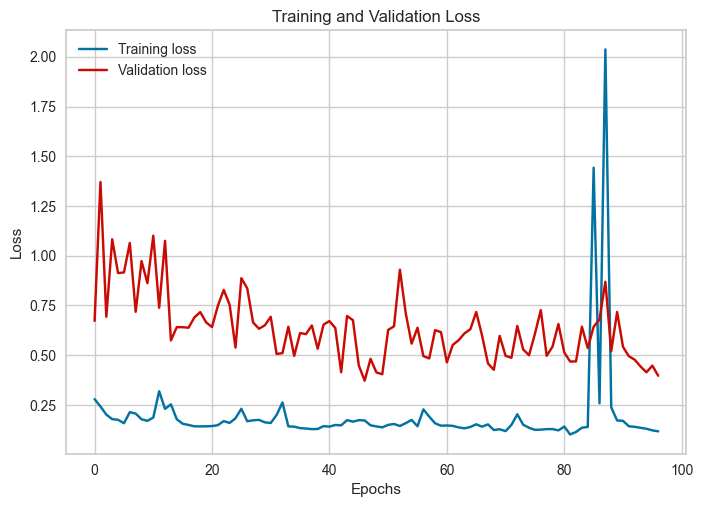

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

1/1 [==============================] - 0s 110ms/step
VAl Mean Squared Error (MSE): 1825248.9460005306
VAl Mean Absolute Error (MAE): 963.9409492718776
VAl Mean Absolute Error (MAPE): 0.2513017214427048
1/1 [==============================] - 0s 10ms/step
Mean Squared Error (MSE): 13736311.358150423
Mean Absolute Error (MAE): 2906.363647460937
Mean Absolute Error (MAPE): 0.3276301579021841


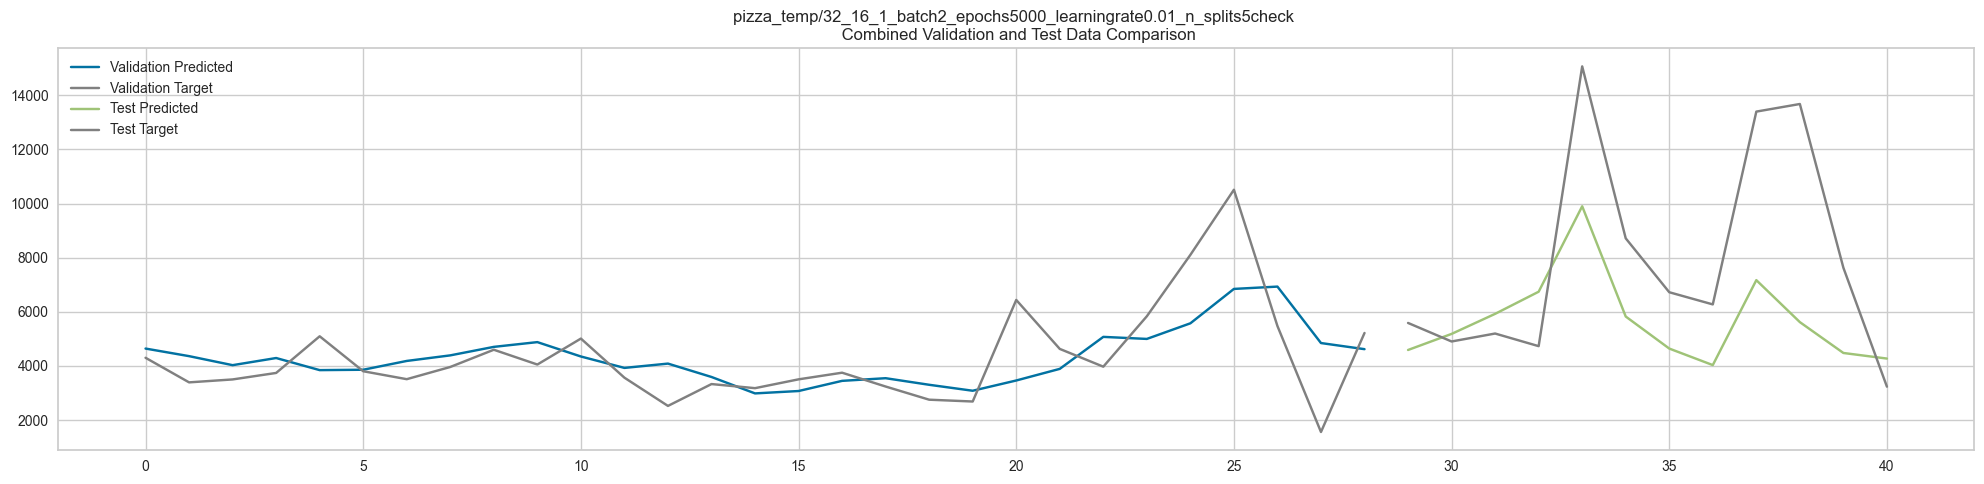

In [ ]:
# predict validation
val_predicted_values = model.predict(X_val_tensor)
val_predicted_values_reversed = (reverse_ln_transformation(val_predicted_values))

y_val_reshaped_reversed = (reverse_ln_transformation(y_val_tensor))
target = np.array([y_val_reshaped_reversed[i][3] for i in range(len(y_val_reshaped_reversed))])

val_mse = mean_squared_error(target, val_predicted_values_reversed)
val_mae = mean_absolute_error(target, val_predicted_values_reversed)
val_mape = mean_absolute_percentage_error(target, val_predicted_values_reversed)

print("VAl Mean Squared Error (MSE):", val_mse)
print("VAl Mean Absolute Error (MAE):", val_mae)
print("VAl Mean Absolute Error (MAPE):", val_mape)

# test
test_predicted_values = model.predict(X_test_tensor)
test_predicted_values_reversed = (reverse_ln_transformation(test_predicted_values))

y_test_reshaped_reversed = (reverse_ln_transformation(y_test_tensor))
test_target = np.array([y_test_reshaped_reversed[i][3] for i in range(len(y_test_reshaped_reversed))])


mse = mean_squared_error(test_target, test_predicted_values_reversed)
mae = mean_absolute_error(test_target, test_predicted_values_reversed)
mape = mean_absolute_percentage_error(test_target, test_predicted_values_reversed)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Error (MAPE):", mape)

# create axis x value 
x_val = range(len(val_predicted_values_reversed)) # 29
x_test = range(len(test_predicted_values_reversed)) # 12

plt.figure(figsize=(20, 5)) 

# Validation graph
plt.plot(x_val, val_predicted_values_reversed, label='Validation Predicted')
plt.plot(x_val, target, label='Validation Target', color = 'gray')

# Test graph
plt.plot([x + len(val_predicted_values_reversed) for x in x_test], test_predicted_values_reversed, label='Test Predicted')
plt.plot([x + len(val_predicted_values_reversed) for x in x_test], test_target, label='Test Target', color = 'gray')

plt.title(f'{full} \n Combined Validation and Test Data Comparison')
plt.legend()

plt.tight_layout()
plt.show()

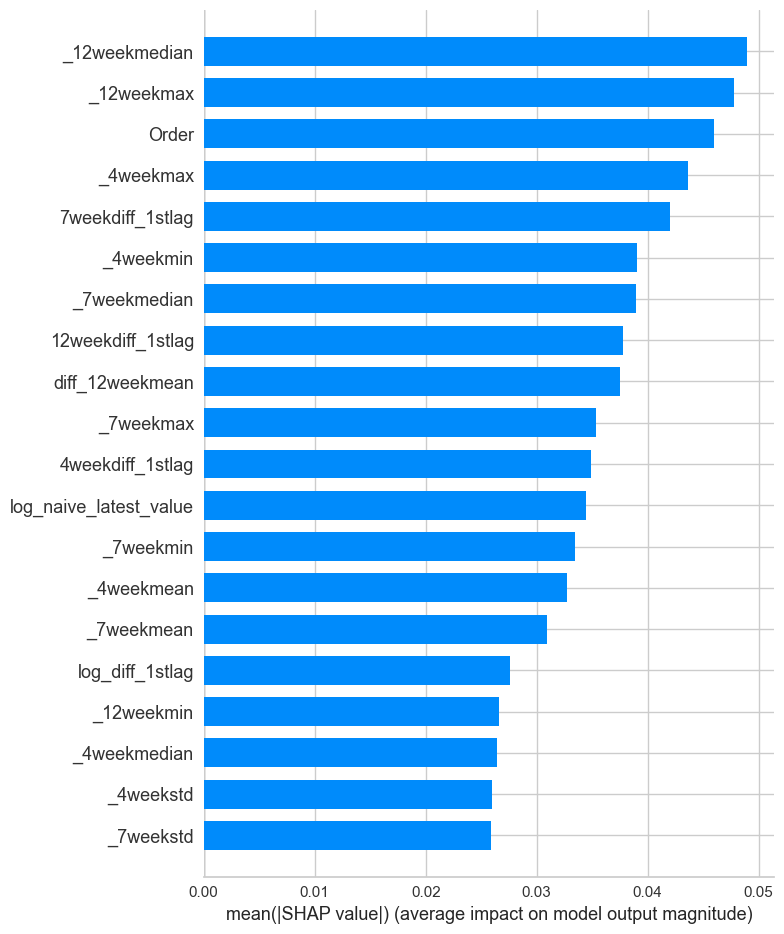

In [ ]:
# checking importance of features
explainer = shap.GradientExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_train_tensor)

shap.summary_plot(shap_values[0][:, 0, :], X_train_tensor[:, 0, :],col,plot_type='bar')

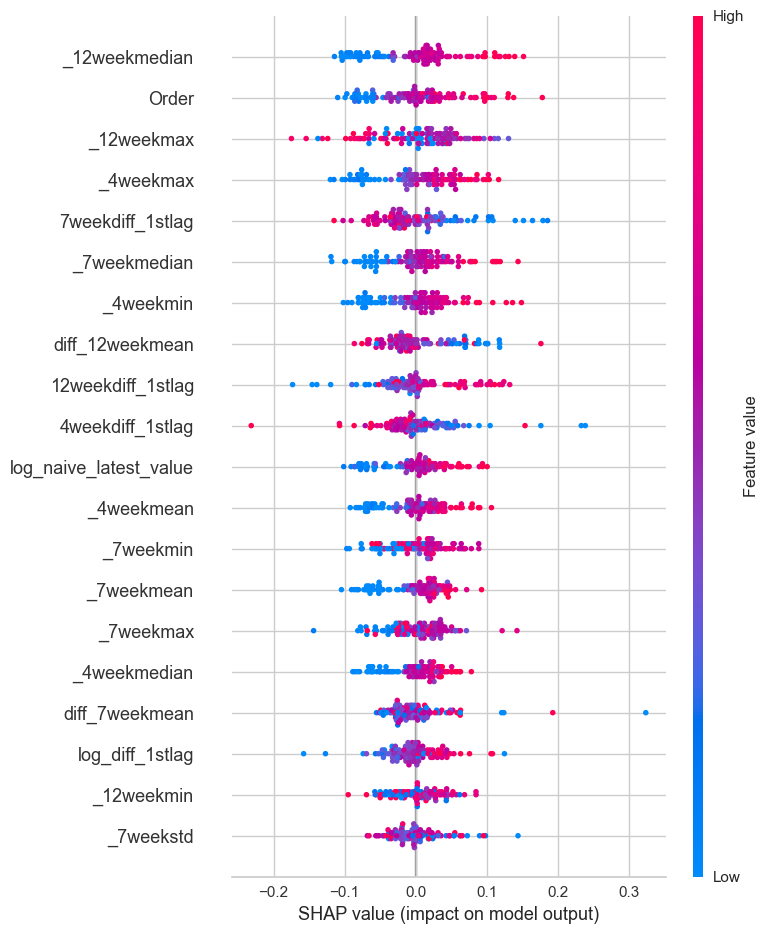

In [ ]:
explainer = shap.GradientExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_train_tensor)

shap.summary_plot(shap_values[0][:, 0, :], X_train_tensor[:, 0, :],col)

# 2. Cutlet
The proportion of this item is moderately significant. \
Training the model to fit the inventory

In [ ]:
# setting data 
X_trainval = pd.read_csv(r'/Users/jiwon/Desktop/ASAC_time_series/dataunified/last_cutlet_X_train.csv', index_col=0, decimal=',')
y_trainval = pd.read_csv(r'/Users/jiwon/Desktop/ASAC_time_series/dataunified/last_cutlet_y_train.csv', index_col=0, decimal=',')

X_test = pd.read_csv(r'/Users/jiwon/Desktop/ASAC_time_series/dataunified/cutlet_X_test.csv', index_col=0, decimal=',')
y_test = pd.read_csv(r'/Users/jiwon/Desktop/ASAC_time_series/dataunified/cutlet_y_test.csv', index_col=0, decimal=',')

pd.set_option('display.float_format', '{:.20f}'.format)
# define function to convert 
def convert_to_float(column):
    return column.astype(float)  

# apply converting function to multiple columns 
X_columns_to_convert = X_trainval.columns
X_trainval[X_columns_to_convert] = X_trainval[X_columns_to_convert].apply(convert_to_float)
X_test[X_columns_to_convert] = X_test[X_columns_to_convert].apply(convert_to_float)

y_columns_to_convert = y_trainval.columns
y_trainval[y_columns_to_convert] = y_trainval[y_columns_to_convert].apply(convert_to_float)
y_test[y_columns_to_convert] = y_test[y_columns_to_convert].apply(convert_to_float)

col=X_trainval.columns
X_train = X_trainval[:int(len(X_trainval)*0.8)] 
X_val = X_trainval[int(len(X_trainval)*0.8):] 

y_train = y_trainval[:int(len(y_trainval)*0.8)] 
y_val = y_trainval[int(len(y_trainval)*0.8):] 

med = np.exp(X_train['Order']).median()
bz_high = 0
bz_low = 0

f preprocess(x_train, x_valid, x_test): 
    tmp_x_train = x_train.copy()
    tmp_x_valid = x_valid.copy()
    tmp_x_test  = x_test.copy()

    tmp_x_train.reset_index(drop=True, inplace=True)
    tmp_x_valid.reset_index(drop=True, inplace=True)
    tmp_x_test.reset_index(drop=True, inplace=True)

    
    cat_columns = tmp_x_train.select_dtypes(include='object').columns # Store the column names before transformation
    num_columns = tmp_x_train.select_dtypes(include=['int', 'float']).columns

    # Apply transformations separately for numerical and categorical columns
    transformer = PowerTransformer(method='yeo-johnson')
    tmp_x_train[num_columns] = transformer.fit_transform(tmp_x_train[num_columns])
    tmp_x_valid[num_columns] = transformer.transform(tmp_x_valid[num_columns])
    tmp_x_test[num_columns]  = transformer.transform(tmp_x_test[num_columns])

    # scaler = StandardScaler(), does not change the shape of scale
    # tmp_x_train[num_columns] = scaler.fit_transform(tmp_x_train[num_columns])
    # tmp_x_valid[num_columns] = scaler.transform(tmp_x_valid[num_columns])
    # tmp_x_test[num_columns]  = scaler.transform(tmp_x_test[num_columns])

    return tmp_x_train, tmp_x_valid, tmp_x_test 

# Assuming you have X_train, X_val, and X_test defined elsewhere
X_train, X_val, X_test = preprocess(X_train, X_val, X_test)


data = X_train['Order'].to_numpy() # X_train['Order'] data to NumPy 
sorted_data = np.sort(data) # sort data 
a50 = abs(np.percentile(sorted_data, 50))
X_trainval = pd.concat([X_train, X_val], axis=0)

X = pd.concat([X_trainval, X_test], axis=0)
X = X.reset_index()
X = X.drop(['index'],axis=1)
# print('X len:', len(X))

X = np.array(X)
sequence_length = 4

# Reshape the training data
X = np.array([X[i:i+sequence_length, :] for i in range(len(X) - sequence_length + 1)]) # split train, val, test 
# y_train_reshaped = y_train_arr[sequence_length - 1:]

X_train_tensor = X[:-(len(X_test)+len(X_val))]
X_val_tensor = X[-(len(X_test)+len(X_val)): -len(X_test)]
X_test_tensor = X[ -len(X_test):]
# print('X_train_tensor:', len(X_train_tensor))
# print('X_val_tensor:', len(X_val_tensor))
# print('X_test_tensor:', len(X_test_tensor))
# print(len(X_train_tensor)+len(X_val_tensor)+len(X_test_tensor))

y = pd.concat([y_trainval, y_test], axis=0)
y = y.reset_index()
y = y.drop(['index'],axis=1)
print('y len:', len(y))

y = np.array(y)
sequence_length = 4

# Reshape the training data
y = np.array([y[i:i+sequence_length, :] for i in range(len(y) - sequence_length + 1)]) # train, val, test 로 나누기
# y_train_reshaped = y_train_arr[sequence_length - 1:]

y_train_tensor = y[:-(len(y_test)+len(y_val))]
y_val_tensor = y[-(len(y_test)+len(y_val)): -len(y_test)]
y_test_tensor = y[ -len(y_test):]

# print('y_train_tensor:', len(y_train_tensor))
# print('y_val_tensor:', len(y_val_tensor))
# print('y_test_tensor:', len(y_test_tensor))

# print(len(y_train_tensor)+len(y_val_tensor)+len(y_test_tensor))

In [ ]:
high = 0 # 양수
low = 0 # 음수0

high = 0 # 양수
low = 0 # 음수
batch_size = 4
epochs = 1000
learning_rate = 0.01
# Create a BlockingTimeSeriesSplit object
n_splits = 3  # Number of splits/folds

folder = '04_data/'
full = f'cutlet/32_16_1_batch{batch_size}_epochs{epochs}_learningrate{learning_rate}_lr{learning_rate}_high{high}_low{low}_check_check'
best_filename = folder+f'{full}.h5'

# print(full)
# print(best_filename)

In [ ]:
# model
sequence_length = X_train_tensor.shape[1]
features = X_train_tensor.shape[2]

model = Sequential()
model.add(LSTM(32,activation='relu', return_sequences=True, input_shape=(sequence_length, features)))  
model.add((LSTM(16, activation='relu')))  
model.add(Dense(1, activation='linear')) 

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=100)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=best_filename,
    verbose=1,
    save_best_only=True,
)

# loss_metric = business_Metrics(high, low)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error')

history=model.fit(X_train_tensor, y_train_tensor, epochs=epochs, batch_size=batch_size,
              validation_data=(X_val_tensor, y_val_tensor),
              callbacks=[es_callback, modelckpt_callback],
              shuffle=False) 


Epoch 83: val_loss did not improve from 0.87551
29/29 [==============================] - 0s 3ms/step - loss: 0.5953 - val_loss: 1.5198
Epoch 84/1000
26/29 [=========================>....] - ETA: 0s - loss: 0.3273
Epoch 84: val_loss did not improve from 0.87551
29/29 [==============================] - 0s 3ms/step - loss: 0.3197 - val_loss: 1.2933
Epoch 85/1000
26/29 [=========================>....] - ETA: 0s - loss: 0.5010
Epoch 85: val_loss did not improve from 0.87551
29/29 [==============================] - 0s 3ms/step - loss: 0.4813 - val_loss: 1.1837
Epoch 86/1000
26/29 [=========================>....] - ETA: 0s - loss: 1.1490
Epoch 86: val_loss did not improve from 0.87551
29/29 [==============================] - 0s 3ms/step - loss: 1.1471 - val_loss: 1.0551
Epoch 87/1000
26/29 [=========================>....] - ETA: 0s - loss: 0.6810
Epoch 87: val_loss did not improve from 0.87551
29/29 [==============================] - 0s 3ms/step - loss: 0.6481 - val_loss: 0.9321
Epoch 88/100

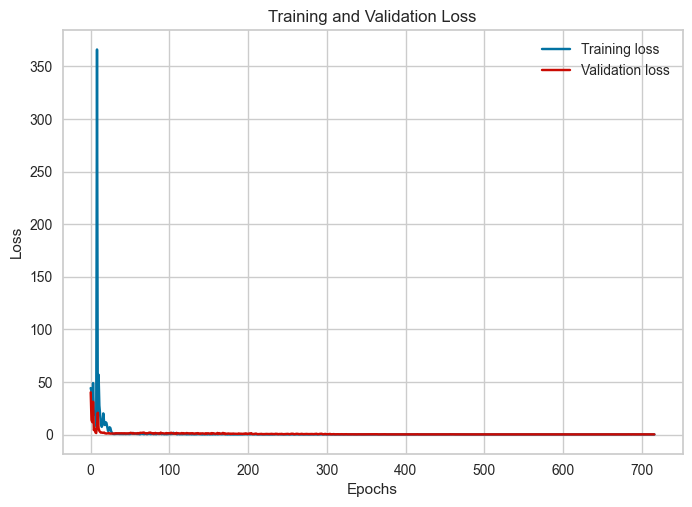

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

1/1 [==============================] - 0s 184ms/step
VAl Mean Squared Error (MSE): 2565174.8920952776
VAl Mean Absolute Error (MAE): 1104.845399135392
VAl Mean Absolute Error (MAPE): 0.36258118146438023
1/1 [==============================] - 0s 15ms/step
Mean Squared Error (MSE): 16732976.274786973
Mean Absolute Error (MAE): 2491.3253987630196
Mean Absolute Error (MAPE): 0.34958272474092555


<Figure size 2000x500 with 0 Axes>

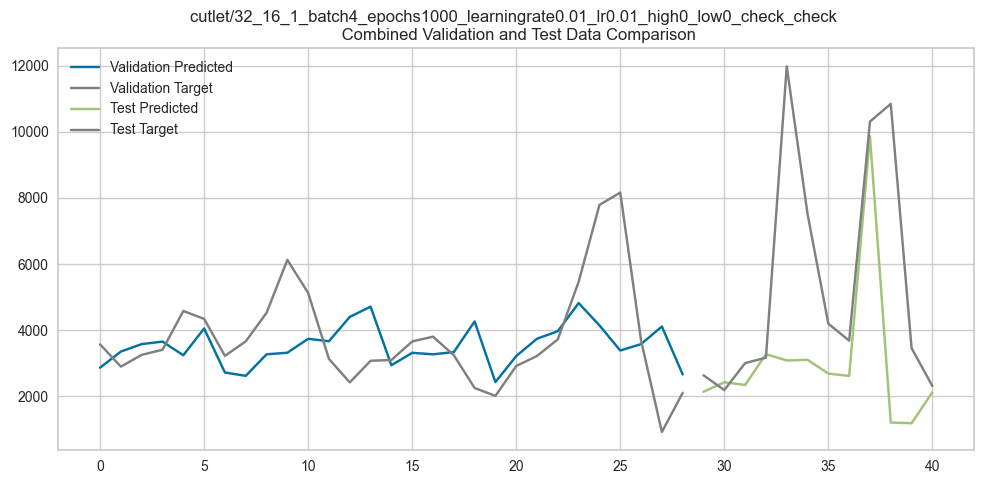

[[2139.608 ]
 [2426.6863]
 [2343.9863]
 [3274.4976]
 [3085.6018]
 [3105.0698]
 [2689.8357]
 [2617.3057]
 [9868.137 ]
 [1208.2942]
 [1188.2856]
 [2125.1553]]
0.34958272474092555


In [ ]:
# predict validation 
val_predicted_values = model.predict(X_val_tensor)
val_predicted_values_reversed = (reverse_ln_transformation(val_predicted_values))

y_val_reshaped_reversed = (reverse_ln_transformation(y_val_tensor))
target = np.array([y_val_reshaped_reversed[i][3] for i in range(len(y_val_reshaped_reversed))])

val_mse = mean_squared_error(target, val_predicted_values_reversed)
val_mae = mean_absolute_error(target, val_predicted_values_reversed)
val_mape = mean_absolute_percentage_error(target, val_predicted_values_reversed)

print("VAl Mean Squared Error (MSE):", val_mse)
print("VAl Mean Absolute Error (MAE):", val_mae)
print("VAl Mean Absolute Error (MAPE):", val_mape)

# test
test_predicted_values = model.predict(X_test_tensor)
test_predicted_values_reversed = (reverse_ln_transformation(test_predicted_values))

y_test_reshaped_reversed = (reverse_ln_transformation(y_test_tensor))
test_target = np.array([y_test_reshaped_reversed[i][3] for i in range(len(y_test_reshaped_reversed))])


mse = mean_squared_error(test_target, test_predicted_values_reversed)
mae = mean_absolute_error(test_target, test_predicted_values_reversed)
mape = mean_absolute_percentage_error(test_target, test_predicted_values_reversed)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Error (MAPE):", mape)

x_val = range(len(val_predicted_values_reversed))
x_test = range(len(test_predicted_values_reversed))

plt.figure(figsize=(20, 5))

plt.figure(figsize=(10, 5))

# Validation graph
plt.plot(x_val, val_predicted_values_reversed, label='Validation Predicted')
plt.plot(x_val, target, label='Validation Target', color = 'gray')

# Test 데이터의 그래프
plt.plot([x + len(val_predicted_values_reversed) for x in x_test], test_predicted_values_reversed, label='Test Predicted')
plt.plot([x + len(val_predicted_values_reversed) for x in x_test], test_target, label='Test Target', color = 'gray')

plt.title(f'{full} \n Combined Validation and Test Data Comparison')
plt.legend()

plt.tight_layout()
plt.show()

print(test_predicted_values_reversed)
print(business_Metrics(0, 0).ml_loss_mape(test_target, test_predicted_values_reversed))

# 3. Hotdog
This product has the lowest proportion in the sales \
Training the model to prevent having the extra inventory

In [ ]:
# setting data
X_trainval = pd.read_csv(r'/Users/hwangjong-won/Desktop/sk/dataset/order_set/last_hotdog_X_train.csv', index_col=0, decimal=',')
y_trainval = pd.read_csv(r'/Users/hwangjong-won/Desktop/sk/dataset/order_set/last_hotdog_y_train.csv', index_col=0, decimal=',')

X_test = pd.read_csv(r'/Users/hwangjong-won/Desktop/sk/dataset/order_set/hotdog_X_test.csv', index_col=0, decimal=',')
y_test = pd.read_csv(r'/Users/hwangjong-won/Desktop/sk/dataset/order_set/hotdog_y_test.csv', index_col=0, decimal=',')

pd.set_option('display.float_format', '{:.20f}'.format)


def convert_to_float(column):
    return column.astype(float)  


X_columns_to_convert = X_trainval.columns
X_trainval[X_columns_to_convert] = X_trainval[X_columns_to_convert].apply(convert_to_float)
X_test[X_columns_to_convert] = X_test[X_columns_to_convert].apply(convert_to_float)

y_columns_to_convert = y_trainval.columns
y_trainval[y_columns_to_convert] = y_trainval[y_columns_to_convert].apply(convert_to_float)
y_test[y_columns_to_convert] = y_test[y_columns_to_convert].apply(convert_to_float)

col=X_trainval.columns
X_train = X_trainval[:int(len(X_trainval)*0.8)] 
X_val = X_trainval[int(len(X_trainval)*0.8):] 

y_train = y_trainval[:int(len(y_trainval)*0.8)] 
y_val = y_trainval[int(len(y_trainval)*0.8):] 

med = np.exp(X_train['Order']).median()
bz_high = med*0.1*0.5 # set differently for each product
bz_low = med*0.1

def preprocess(x_train, x_valid, x_test): 
    tmp_x_train = x_train.copy()
    tmp_x_valid = x_valid.copy()
    tmp_x_test  = x_test.copy()

    tmp_x_train.reset_index(drop=True, inplace=True)
    tmp_x_valid.reset_index(drop=True, inplace=True)
    tmp_x_test.reset_index(drop=True, inplace=True)

    
    cat_columns = tmp_x_train.select_dtypes(include='object').columns # Store the column names before transformation
    num_columns = tmp_x_train.select_dtypes(include=['int', 'float']).columns

    # Apply transformations separately for numerical and categorical columns
    transformer = PowerTransformer(method='yeo-johnson')
    tmp_x_train[num_columns] = transformer.fit_transform(tmp_x_train[num_columns])
    tmp_x_valid[num_columns] = transformer.transform(tmp_x_valid[num_columns])
    tmp_x_test[num_columns]  = transformer.transform(tmp_x_test[num_columns])

    # scaler = StandardScaler(), does not change the shape of scale
    # tmp_x_train[num_columns] = scaler.fit_transform(tmp_x_train[num_columns])
    # tmp_x_valid[num_columns] = scaler.transform(tmp_x_valid[num_columns])
    # tmp_x_test[num_columns]  = scaler.transform(tmp_x_test[num_columns])

    return tmp_x_train, tmp_x_valid, tmp_x_test 

# Assuming you have X_train, X_val, and X_test defined elsewhere
X_train, X_val, X_test = preprocess(X_train, X_val, X_test)


data = X_train['Order'].to_numpy() # X_train['Order'] data to NumPy 
sorted_data = np.sort(data) # sort data 
a50 = abs(np.percentile(sorted_data, 50))
X_trainval = pd.concat([X_train, X_val], axis=0)

X = pd.concat([X_trainval, X_test], axis=0)
X = X.reset_index()
X = X.drop(['index'],axis=1)
print('X len:', len(X))

X = np.array(X)
sequence_length = 4

# Reshape the training data
X = np.array([X[i:i+sequence_length, :] for i in range(len(X) - sequence_length + 1)]) # split train, val, test 
# y_train_reshaped = y_train_arr[sequence_length - 1:]

X_train_tensor = X[:-(len(X_test)+len(X_val))]
X_val_tensor = X[-(len(X_test)+len(X_val)): -len(X_test)]
X_test_tensor = X[ -len(X_test):]
print('X_train_tensor:', len(X_train_tensor))
print('X_val_tensor:', len(X_val_tensor))
print('X_test_tensor:', len(X_test_tensor))
print(len(X_train_tensor)+len(X_val_tensor)+len(X_test_tensor))

X len: 84
X_train_tensor: 54
X_val_tensor: 15
X_test_tensor: 12
81


In [ ]:
high = a50*0.1*0.5 # positive value
low = -(a50*0.1) # negative value
batch_size = 2
epochs = 5000
# Create a BlockingTimeSeriesSplit object
n_splits = 4  # Number of splits/folds
learning_rate = 0.01

folder = 'last_model/'
full = f'hotdog_temp/32_16_1_batch{batch_size}_epochs{epochs}_learningrate{learning_rate}_n_splits{n_splits}_v1'
best_filename = folder+f'{full}.h5'

print(full)
print(best_filename)

hotdog_temp/32_16_1_batch2_epochs5000_learningrate0.01_n_splits4_v1
last_model/hotdog_temp/32_16_1_batch2_epochs5000_learningrate0.01_n_splits4_v1.h5


In [ ]:
data = np.concatenate((X_train_tensor, y_train_tensor), axis=2)
tscv = TimeSeriesSplit(n_splits=n_splits)
sequence_length = X_train_tensor.shape[1]
features = X_train_tensor.shape[2]

model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(sequence_length, features)))  
model.add(LSTM(16, activation='relu'))  
model.add(Dense(1, activation='linear'))  

loss_metric = business_Metrics(high, low)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss_metric.custom_loss)

# Perform training and validation for each fold.
for train_idx, val_idx in tscv.split(data):
    X_train_fold = data[train_idx, :, :-1]
    y_train_fold = data[train_idx, :, -1]
    X_val_fold = data[val_idx, :, :-1]
    y_val_fold = data[val_idx, :, -1]

    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=50)
    
    modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=best_filename,
        verbose=1,
        save_best_only=True,
    )

    history = model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[es_callback, modelckpt_callback],
                        shuffle=False)

Epoch 1/5000


1/7 [===>..........................] - ETA: 2s - loss: 48.7027
Epoch 1: val_loss improved from inf to 19.30919, saving model to last_model/hotdog_temp/32_16_1_batch2_epochs5000_learningrate0.01_n_splits4_v1.h5
7/7 [==============================] - 1s 22ms/step - loss: 43.3399 - val_loss: 19.3092
Epoch 2/5000
1/7 [===>..........................] - ETA: 0s - loss: 161.0368
Epoch 2: val_loss improved from 19.30919 to 2.44415, saving model to last_model/hotdog_temp/32_16_1_batch2_epochs5000_learningrate0.01_n_splits4_v1.h5
7/7 [==============================] - 0s 4ms/step - loss: 35.8768 - val_loss: 2.4442
Epoch 3/5000
1/7 [===>..........................] - ETA: 0s - loss: 23.1819
Epoch 3: val_loss did not improve from 2.44415
7/7 [==============================] - 0s 4ms/step - loss: 15.9919 - val_loss: 4.4507
Epoch 4/5000
1/7 [===>..........................] - ETA: 0s - loss: 25.1642
Epoch 4: val_loss did not improve from 2.44415
7/7 [==============================] - 0s 3ms/step - los

In [ ]:
# validation with the best model
X_train_val_tensor = np.concatenate((X_train_tensor, X_val_tensor), axis=0)
y_train_val_tensor = np.concatenate((y_train_tensor, y_val_tensor), axis=0)
previous_model = tf.keras.models.load_model(best_filename, 
                 custom_objects={'custom_loss': business_Metrics(high,low).custom_loss})
learning_rate = previous_model.optimizer.lr.numpy()  

sequence_length = X_train_val_tensor.shape[1]
features = X_train_val_tensor.shape[2]

model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(sequence_length, features)))  
model.add(LSTM(16, activation='relu'))  
model.add(Dense(1, activation='linear'))  
model.set_weights(previous_model.get_weights())

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_metric.custom_loss)

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=50)
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=best_filename,
    verbose=1,
    save_best_only=True,
)
data = np.concatenate((X_train_val_tensor, y_train_val_tensor), axis=2)
history = model.fit(X_train_val_tensor, y_train_val_tensor, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test_tensor, y_test_tensor),
                        callbacks=[es_callback, modelckpt_callback],
                        shuffle=False)
model.save('new_model.h5')

Epoch 1/5000
21/35 [=================>............] - ETA: 0s - loss: 1.1893 
Epoch 1: val_loss improved from inf to 8.93959, saving model to last_model/hotdog_temp/32_16_1_batch2_epochs5000_learningrate0.01_n_splits4_v1.h5
35/35 [==============================] - 1s 6ms/step - loss: 4.1616 - val_loss: 8.9396
Epoch 2/5000
33/35 [===========================>..] - ETA: 0s - loss: 1.8592
Epoch 2: val_loss improved from 8.93959 to 3.18951, saving model to last_model/hotdog_temp/32_16_1_batch2_epochs5000_learningrate0.01_n_splits4_v1.h5
35/35 [==============================] - 0s 2ms/step - loss: 1.8290 - val_loss: 3.1895
Epoch 3/5000
33/35 [===========================>..] - ETA: 0s - loss: 1.4549
Epoch 3: val_loss did not improve from 3.18951
35/35 [==============================] - 0s 2ms/step - loss: 1.4052 - val_loss: 3.3734
Epoch 4/5000
33/35 [===========================>..] - ETA: 0s - loss: 1.5589
Epoch 4: val_loss did not improve from 3.18951
35/35 [==============================] -

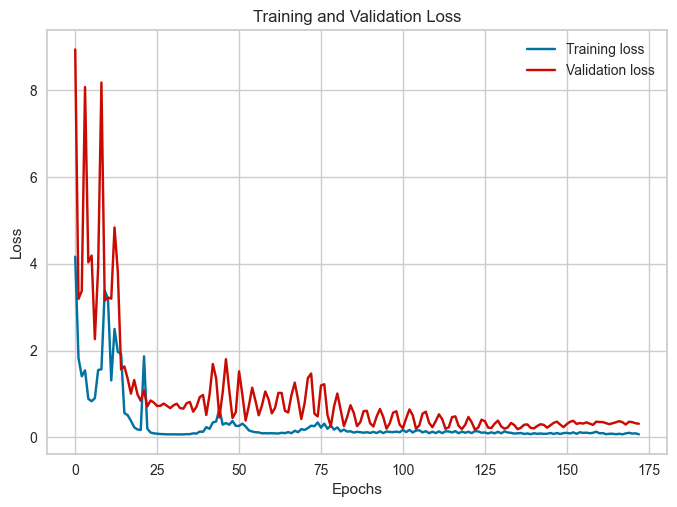

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

1/1 [==============================] - 0s 103ms/step
VAl Mean Squared Error (MSE): 891019.6374904888
VAl Mean Absolute Error (MAE): 840.0207792512374
VAl Mean Absolute Error (MAPE): 0.2879322158491507
1/1 [==============================] - 0s 9ms/step
Mean Squared Error (MSE): 527445.0827615099
Mean Absolute Error (MAE): 590.4584401448566
Mean Absolute Error (MAPE): 0.31958573320445294


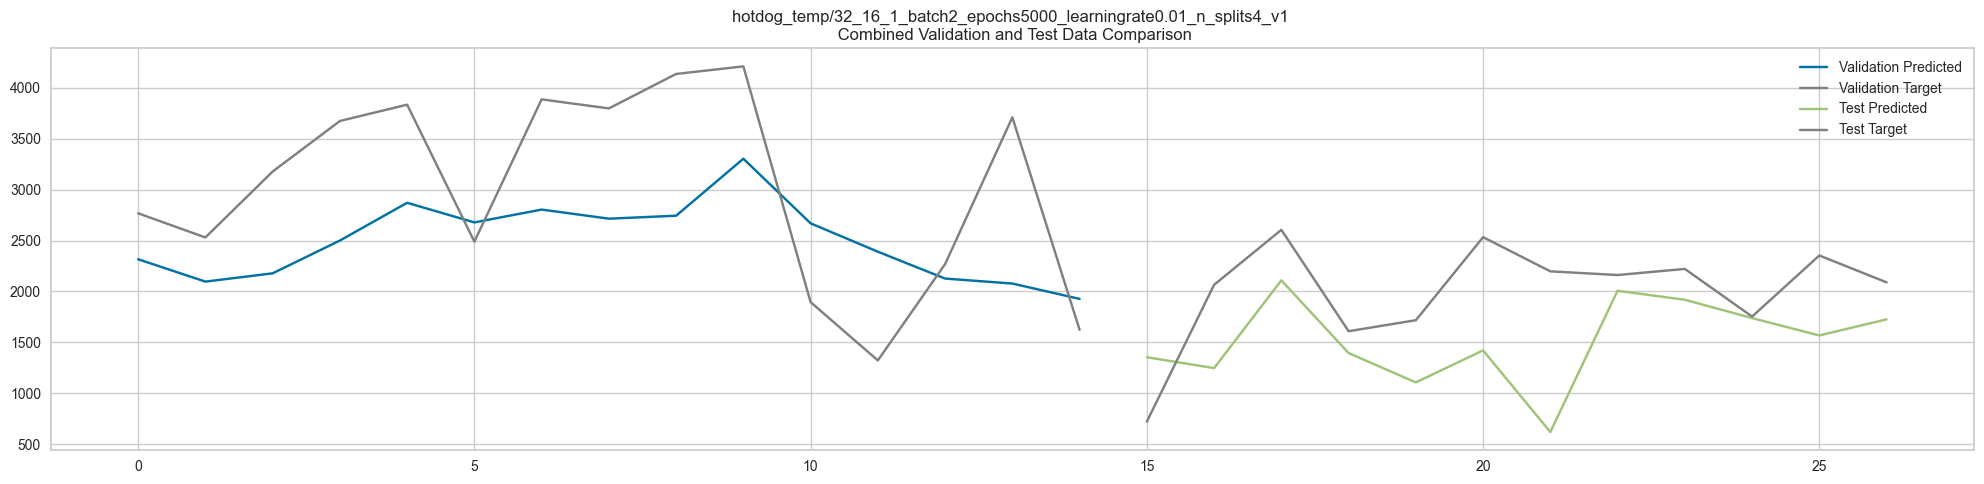

In [ ]:
# predit validation 
val_predicted_values = model.predict(X_val_tensor)
val_predicted_values_reversed = (reverse_ln_transformation(val_predicted_values))

y_val_reshaped_reversed = (reverse_ln_transformation(y_val_tensor))
target = np.array([y_val_reshaped_reversed[i][3] for i in range(len(y_val_reshaped_reversed))])

val_mse = mean_squared_error(target, val_predicted_values_reversed)
val_mae = mean_absolute_error(target, val_predicted_values_reversed)
val_mape = mean_absolute_percentage_error(target, val_predicted_values_reversed)

print("VAl Mean Squared Error (MSE):", val_mse)
print("VAl Mean Absolute Error (MAE):", val_mae)
print("VAl Mean Absolute Error (MAPE):", val_mape)

# test
test_predicted_values = model.predict(X_test_tensor)
test_predicted_values_reversed = (reverse_ln_transformation(test_predicted_values))

y_test_reshaped_reversed = (reverse_ln_transformation(y_test_tensor))
test_target = np.array([y_test_reshaped_reversed[i][3] for i in range(len(y_test_reshaped_reversed))])


mse = mean_squared_error(test_target, test_predicted_values_reversed)
mae = mean_absolute_error(test_target, test_predicted_values_reversed)
mape = mean_absolute_percentage_error(test_target, test_predicted_values_reversed)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Error (MAPE):", mape)

x_val = range(len(val_predicted_values_reversed))
x_test = range(len(test_predicted_values_reversed))


plt.figure(figsize=(20, 5))

plt.plot(x_val, val_predicted_values_reversed, label='Validation Predicted')
plt.plot(x_val, target, label='Validation Target', color = 'gray')

plt.plot([x + len(val_predicted_values_reversed) for x in x_test], test_predicted_values_reversed, label='Test Predicted')
plt.plot([x + len(val_predicted_values_reversed) for x in x_test], test_target, label='Test Target', color = 'gray')

plt.title(f'{full} \n Combined Validation and Test Data Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# loaded_model = load_model(r'04_data/pizza/32_16_1_batch4_high0.014941494539277879_low-0.0074707472696389395_epochs5000_nsplits5_learningrate0.01_epochs5000.h5', 
#                 custom_objects={'custom_loss': business_Metrics(0.01494149453927787, 0.01494149453927787).custom_loss})


# Perform predictions by directly passing the test data to the model.
test_predicted_values = model(X_test_tensor)
test_predicted_values_reversed = reverse_ln_transformation(test_predicted_values)

# reverse y_test
y_test_reshaped_reversed = reverse_ln_transformation(y_test_tensor)
test_target = np.array([y_test_reshaped_reversed[i][3] for i in range(len(y_test_reshaped_reversed))])

print(business_Metrics(0, -bz_low).ml_loss_mape1(test_target, test_predicted_values_reversed))
print(test_predicted_values_reversed)

0.27357074945468673
[[1353.02  ]
 [1361.2704]
 [2223.5361]
 [1508.5972]
 [1220.8988]
 [1535.0736]
 [ 733.4123]
 [2121.1938]
 [2032.6434]
 [1753.    ]
 [1681.979 ]
 [1840.0936]]


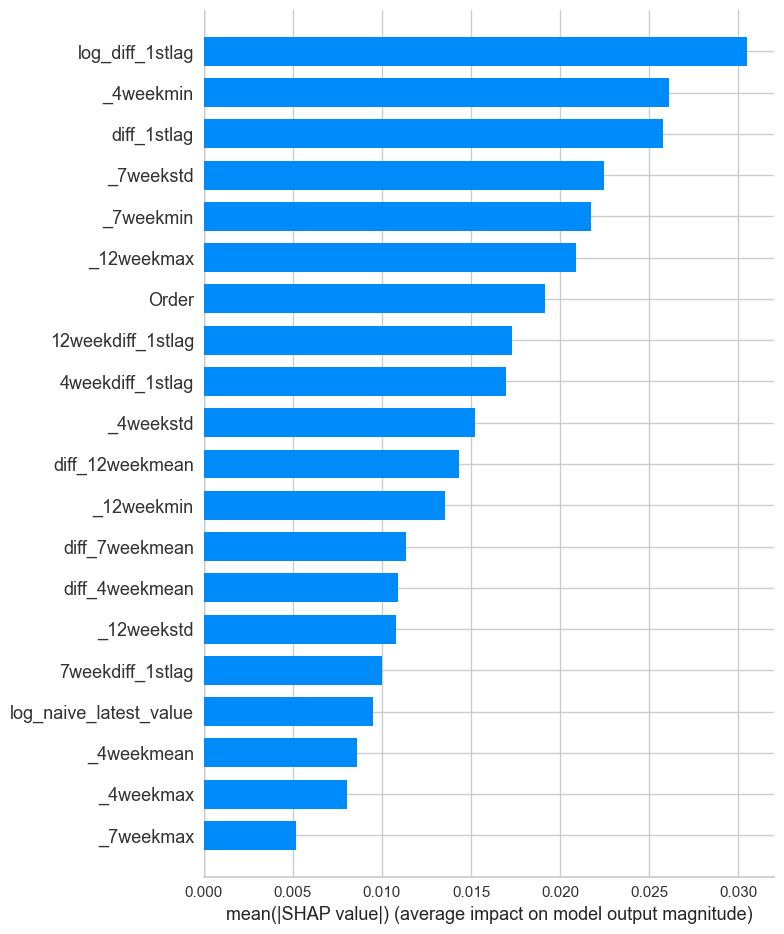

In [ ]:
import shap
explainer = shap.GradientExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_train_tensor)

shap.summary_plot(shap_values[0][:, 0, :], X_train_tensor[:, 0, :],col,plot_type='bar')

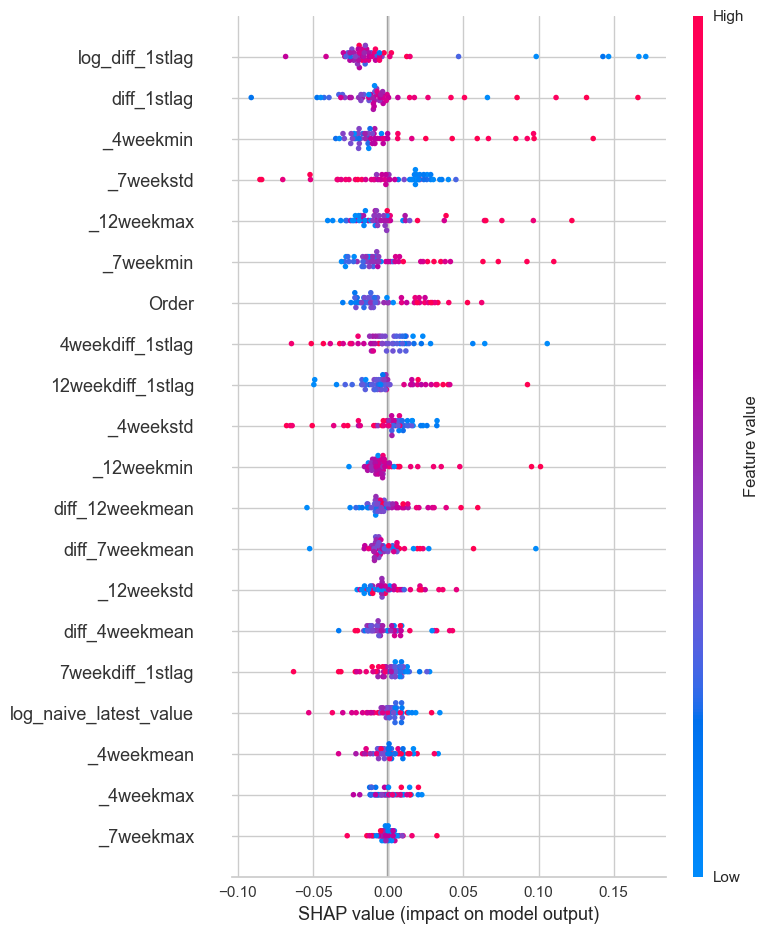

In [ ]:
explainer = shap.GradientExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_train_tensor)
shap.summary_plot(shap_values[0][:, 0, :], X_train_tensor[:, 0, :],col)